## 1. Parâmetros do Problema:

* Condutividade térmica ($k$): $25 \, \text{W/mK}$.

* Capacidade calorífica volumétrica ($\rho c_p$): $10 \, \text{MJ/m}^3\text{K} = 10 \times 10^6 \, \text{J/m}^3\text{K}$.

* Difusividade térmica ($\alpha$): $\alpha = \frac{k}{\rho c_p} = \frac{25}{10 \times 10^6} = 2,5 \times 10^{-6} \, \text{m}^2/\text{s}$.

* Comprimento da barra ($L$): $0,1 \, \text{m}$.

* Temperatura inicial ($T_i$): $150^\circ\text{C}$.

* Condições de Contorno: Isolada em $x=0$ ($\frac{\partial T}{\partial x} = 0$) e $0^\circ\text{C}$ em $x=L$.

* Tempo de simulação: $0$ a $360 \, \text{s}$.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# 1. Definição dos Parâmetros do Problema (Lista 6)
k = 25.0                    # W/mK
rho_cp = 10e6               # J/m³K (10 MJ/m³K)
alpha = k / rho_cp          # m²/s
L = 0.1                     # m
Ti = 150.0                  # Temperatura inicial (°C)
TL = 0.0                    # Temperatura em x=L (°C)
t_final = 360               # s
dt = 1                      # Passo de tempo (s)
n_cv = 30                   # Número de volumes de controle

## 2. Formulação Analítica

A solução é dada pela série:

$$T(x,t)=T_{i} \left\{ \frac{4}{\pi} \sum_{n=1}^{\infty} \left[ \frac{(-1)^{n+1}}{2n-1} \right] \exp(-\alpha \lambda_{n}^{2} t) \cos(\lambda_{n} x) \right\}$$

Onde os autovalores são $\lambda_{n}=\frac{(2n-1)\pi}{2L}$.

Código para calcular a solução, gerar os gráficos e criar a animação do perfil de temperatura.

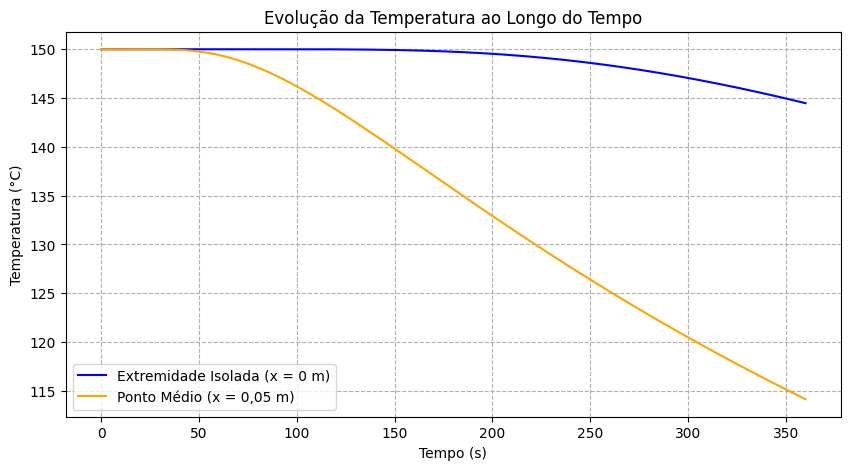

In [5]:

# 2. Implementação da Solução Analítica (Série de Fourier)
def solucao_analitica(x, t, Ti, L, alpha, n_termos=100):
    if t == 0: return np.full_like(x, Ti)
    soma = np.zeros_like(x)
    for n in range(1, n_termos + 1):
        lambda_n = (2 * n - 1) * np.pi / (2 * L)
        termo = ((-1)**(n + 1) / (2 * n - 1)) * np.exp(-alpha * (lambda_n**2) * t) * np.cos(lambda_n * x)
        soma = soma + termo
    return Ti * (4 / np.pi) * soma

# 3. Preparação dos Dados para Gráficos Temporais
tempos = np.linspace(0, t_final, 400)
T_x0 = [solucao_analitica(np.array([0.0]), t, Ti, L, alpha)[0] for t in tempos]
T_mid = [solucao_analitica(np.array([L/2]), t, Ti, L, alpha)[0] for t in tempos]

# Plotagem: Temperatura no ponto médio e x=0 vs Tempo
plt.figure(figsize=(10, 5))
plt.plot(tempos, T_x0, label='Extremidade Isolada (x = 0 m)', color='blue')
plt.plot(tempos, T_mid, label='Ponto Médio (x = 0,05 m)', color='orange')
plt.title('Evolução da Temperatura ao Longo do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# 4. Configuração da Animação (Perfil de Temperatura na Barra)
fig, ax = plt.subplots(figsize=(10, 6))
x_grid = np.linspace(0, L, 200)
line, = ax.plot([], [], lw=2, color='red')
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

ax.set_xlim(0, L)
ax.set_ylim(-5, Ti + 10)
ax.set_xlabel('Posição na Barra x (m)')
ax.set_ylabel('Temperatura (°C)')
ax.set_title('Animação: Perfil de Temperatura na Barra (Solução Analítica)')
ax.grid(True)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def update(frame):
    t = frame
    y = solucao_analitica(x_grid, t, Ti, L, alpha)
    line.set_data(x_grid, y)
    time_text.set_text(f'Tempo = {t:.1f} s')
    return line, time_text

# Criação da animação
frames_tempo = np.linspace(0, t_final, 100)
ani = FuncAnimation(fig, update, frames=frames_tempo, init_func=init, blit=True)

# Fechar o plot estático para mostrar apenas a animação
plt.close()

# Exibir a animação no Jupyter Notebook
#HTML(ani.to_jshtml())

## 3. Solução numérica

### 3.1 Equação discretizada

Para o regime transiente, a equação governante de condução 1D sem termo-fonte é:

$$\rho c_{p} \frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right)$$

No Esquema Totalmente Implícito, a integração no espaço e no tempo resulta na equação algébrica para um nó interno $P$:

$$a_{P} T_{P} = a_{W} T_{W} + a_{E} T_{E} + a_{P}^{0} T_{P}^{0}$$

Onde os coeficientes são definidos como:

* $a_{W} = \frac{k}{\Delta x}$

* $a_{E} = \frac{k}{\Delta x}$

* $a_{P}^{0} = \frac{\rho c_{p} \Delta x}{\Delta t}$

* $a_{P} = a_{W} + a_{E} + a_{P}^{0}$

### 3.2 Condições de contorno

#### 3.2.1 Condição de Neumann em regime transiente

#### Equação Governante e Integração

A conservação de energia para a condução unidimensional transiente é dada por:

$$\rho c_{p} \frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) + S$$

Realizamos a integração sobre o volume de controle (VC) e sobre o intervalo de tempo $\Delta t$:

$$\int_{t}^{t+\Delta t} \int_{w}^{e} \rho c_{p} \frac{\partial T}{\partial t} dx dt = \int_{t}^{t+\Delta t} \int_{w}^{e} \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) dx dt + \int_{t}^{t+\Delta t} \int_{w}^{e} S dx dt$$

#### Discretização dos Termos

#### Termo Transiente:

Assumindo que a temperatura no ponto nodal $P$ é uniforme no VC:

$$\rho c_{p} \Delta x (T_{P} - T_{P}^{0})$$

Onde $T_{P}$ é a temperatura no novo tempo e $T_{P}^{0}$ no tempo anterior.

#### Termo de Difusão (Espacial): 

Avaliamos os fluxos nas faces do VC:

$$\left( k \frac{\partial T}{\partial x} \right)_{e} - \left( k \frac{\partial T}{\partial x} \right)_{w}$$

#### Termo-Fonte:

Linearizamos como $S \Delta x = S_{c} \Delta x + S_{p} \Delta x T_{P}$.

#### Aplicação da Condição de Neumann na Fronteira

Considere que a face oeste ($w$) do volume de controle coincide com a fronteira física em $x=0$, onde o fluxo de calor $q''_{B}$ é prescrito.

Face Leste (Interna): Aproximamos por diferenças centrais entre os nós $P$ e $E$:

$$\left( k \frac{\partial T}{\partial x} \right)_{e} \approx k_{e} \frac{T_{E} - T_{P}}{(\delta x)_{e}} = a_{E}(T_{E} - T_{P})$$

Face Oeste (Fronteira): De acordo com a Lei de Fourier ($q = -k \frac{dT}{dx}$), o termo de fluxo na fronteira é substituído diretamente pelo valor prescrito:

$$\left( k \frac{\partial T}{\partial x} \right)_{w} = -q''_{B}$$

Dessa forma, o termo de difusão espacial torna-se: 

$$a_{E}(T_{E} - T_{P}) - (-q''_{B}) = a_{E}(T_{E} - T_{P}) + q''_{B}$$

#### Formulação Temporal Generalizada ($f$)

Aplicamos o parâmetro de ponderação $f$ para integrar os termos espaciais no tempo:

$$\rho c_{p} \frac{\Delta x}{\Delta t} (T_{P} - T_{P}^{0}) = f [ a_{E}(T_{E} - T_{P}) + q''_{B} + S_{c} \Delta x + S_{p} \Delta x T_{P} ] + (1-f) [ a_{E}(T_{E}^{0} - T_{P}^{0}) + {q''_{B}}^{0} + S_{c} \Delta x + S_{p} \Delta x T_{P}^{0} ]$$

#### Equação Discretizada Final

Agrupando os termos de $T_{P}$, $T_{E}$ e $T_{P}^{0}$, obtemos a forma padrão da equação para o nó de fronteira:

* Definição dos Coeficientes:Transiente: $a_{P}^{0} = \frac{\rho c_{p} \Delta x}{\Delta t}$

* Vizinho Leste: $a_{E} = \frac{k_{e}}{(\delta x)_{e}}$

* Nó Central: $a_{P} = a_{P}^{0} + f(a_{E} - S_{p} \Delta x)$

Equação Final:

$$a_{P} T_{P} = a_{E} [ f T_{E} + (1-f) T_{E}^{0} ] + [ a_{P}^{0} - (1-f)(a_{E} - S_{p} \Delta x) ] T_{P}^{0} + [ f q''_{B} + (1-f) {q''_{B}} ^ {0} ] + S_{c} \Delta x$$

No Esquema Totalmente Implícito ($f=1$), a equação simplifica para 

$$a_{P} T_{P} = a_{E} T_{E} + a_{P}^{0} T_{P}^{0} + q''_{B} + S_{c} \Delta x$$

Como, no problema proposto, a parede é isolada em $x=0$ ($q''_b=0$):

$$a_{P} T_{P} = a_{E} T_{E} + a_{P}^{0} T_{P}^{0} + S_{c} \Delta x$$


#### 3.2.2 Condição de Dirichlet em regime transiente

#### Equação Governante e Integração

A conservação de energia para a condução unidimensional transiente é dada por:

$$\rho c_{p} \frac{\partial T}{\partial t} = \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) + S$$

Integrando sobre o volume de controle (VC) e sobre o intervalo de tempo $\Delta t$:

$$\int_{t}^{t+\Delta t} \int_{VC} \rho c_{p} \frac{\partial T}{\partial t} dV dt = \int_{t}^{t+\Delta t} \int_{VC} \frac{\partial}{\partial x} \left( k \frac{\partial T}{\partial x} \right) dV dt + \int_{t}^{t+\Delta t} \int_{VC} S dV dt$$

#### Discretização dos Termos

#### Termo Transiente:

Assumindo que a temperatura no ponto nodal $P$ é uniforme no VC:

$$\rho c_{p} \Delta x (T_{P} - T_{P}^{0})$$

Onde $T_{P}$ é a temperatura no novo tempo e $T_{P}^{0}$ no tempo anterior.

#### Termo de Difusão (Espacial): 

Avaliamos os fluxos nas faces do VC:

Considerando um volume de controle adjacente à fronteira oeste ($x=0$), onde a temperatura de Dirichlet $T_{B}$ é prescrita.

* Face Leste ($e$): O fluxo é aproximado por diferenças centrais entre os nós $P$ e $E$:

$$\left( k \frac{\partial T}{\partial x} \right)_{e} \approx k_{e} \frac{T_{E} - T_{P}}{(\delta x)_{e}} = a_{E}(T_{E} - T_{P})$$

* Face Oeste ($w$ - Fronteira): Como o valor de $T$ na face é conhecido ($T_{B}$), o gradiente é calculado entre a fronteira e o nó $P$. 

A distância $(\delta x)_{w}$ é igual a $\Delta x / 2$ para uma malha uniforme:

$$\left( k \frac{\partial T}{\partial x} \right)_{w} \approx k_{B} \frac{T_{P} - T_{B}}{(\delta x)_{w}} = a_{B}(T_{P} - T_{B})$$

Onde definimos o coeficiente da fronteira como $a_{B} = \frac{k_{B}}{(\delta x)_{w}}$

#### Termo-Fonte:

Linearizamos como $S \Delta x = S_{c} \Delta x + S_{p} \Delta x T_{P}$.

#### Formulação Temporal Generalizada ($f$)

Aplicando esta ponderação aos termos de difusão e à fonte linearizada ($S \Delta x = S_{c} \Delta x + S_{p} \Delta x T_{P}$), a equação completa torna-se:

$$\rho c_{p} \frac{\Delta x}{\Delta t} (T_{P} - T_{P}^{0}) = f \left[ a_{E}(T_{E} - T_{P}) - a_{B}(T_{P} - T_{B}) + S_{c} \Delta x + S_{p} \Delta x T_{P} \right] + (1-f) \left[ a_{E}(T_{E}^{0} - T_{P}^{0}) - a_{B}(T_{P}^{0} - T_{B}^{0}) + S_{c} \Delta x + S_{p} \Delta x T_{P}^{0} \right]$$

#### Equação Discretizada Final

Reorganizando os termos para a forma padrão $a_{P} T_{P} = a_{E} [f T_{E} + (1-f) T_{E}^{0}] + b$, definimos os coeficientes:

* Coeficiente transiente: $a_{P}^{0} = \frac{\rho c_{p} \Delta x}{\Delta t}$

* Coeficiente do nó vizinho: $a_{E} = \frac{k_{e}}{(\delta x)_{e}}$

* Coeficiente da fronteira: $a_{B} = \frac{k_{B}}{(\delta x)_{w}}$

* Coeficiente do nó central: $a_{P} = a_{P}^{0} + f(a_{E} + a_{B} - S_{p} \Delta x)$

A equação final para o nó da fronteira de Dirichlet é:

$$a_{P} T_{P} = a_{E} [f T_{E} + (1-f) T_{E}^{0}] + a_{B} [f T_{B} + (1-f) T_{B}^{0}] + [a_{P}^{0} - (1-f)(a_{E} + a_{B} - S_{p} \Delta x)] T_{P}^{0} + S_{c} \Delta x$$

No Esquema Totalmente Implícito ($f=1$), a equação simplifica para: 

$$a_{P} T_{P} = a_{E} T_{E} + a_{B} T_{B} + a_{P}^{0} T_{P}^{0} + S_{c} \Delta x$$

com $a_{P} = a_{E} + a_{B} + a_{P}^{0} - S_{p} \Delta x$

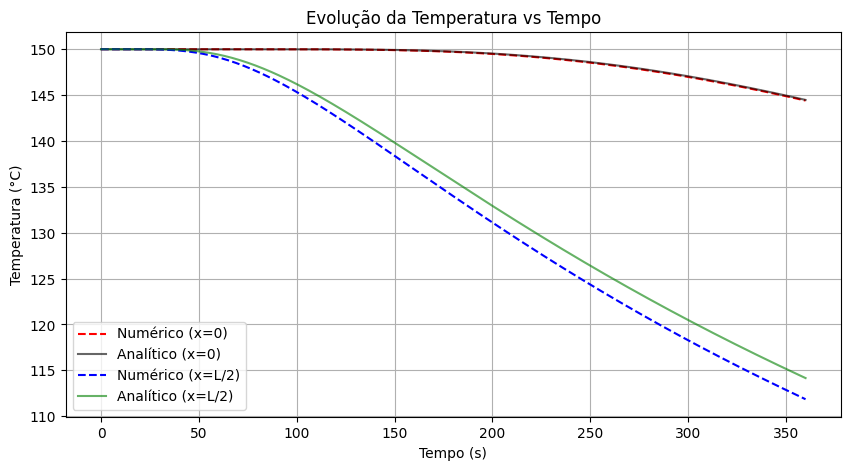

In [6]:
import matplotlib.pyplot as plt

def solver_tdma(a, b, c, d):
    """Algoritmo de Thomas para sistemas tridiagonais"""
    n = len(d)
    c_star = np.zeros(n)
    d_star = np.zeros(n)
    c_star[0] = c[0] / b[0]
    d_star[0] = d[0] / b[0]
    for i in range(1, n):
        m = b[i] - a[i] * c_star[i-1]
        c_star[i] = c[i] / m
        d_star[i] = (d[i] - a[i] * d_star[i-1]) / m
    x = np.zeros(n)
    x[-1] = d_star[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_star[i] - c_star[i] * x[i+1]
    return x

# 3. FUNÇÃO PARA CALCULAR COEFICIENTES (Segundo Enfoque - Implícito)
def calcular_coeficientes_transiente(n_cv, dx, dt, k, rho_cp, T_old, TL):
    a = np.zeros(n_cv)  # inferior
    b = np.zeros(n_cv)  # principal
    c = np.zeros(n_cv)  # superior
    d = np.zeros(n_cv)  # RHS
    
    a_P0 = (rho_cp * dx) / dt
    
    for i in range(n_cv):
        aw = k / dx
        ae = k / dx
        sc, sp = 0, 0
        
        if i == 0: # Fronteira x=0 (Isolada)
            aw = 0
        elif i == n_cv - 1: # Fronteira x=L (Dirichlet)
            ae = 0
            a_face = k / (dx / 2) # Segundo Enfoque
            sc = a_face * TL
            sp = -a_face
            
        b[i] = aw + ae + a_P0 - sp
        a[i] = -aw
        c[i] = -ae
        d[i] = a_P0 * T_old[i] + sc
        
    return a, b, c, d


# 5. LOOP DE SIMULAÇÃO
dx = L / n_cv
x_nos = np.linspace(dx/2, L - dx/2, n_cv)
x_plot = np.concatenate(([0], x_nos, [L])) # Para incluir as fronteiras no plot

T_atual = np.full(n_cv, Ti)
tempos = np.arange(0, t_final + dt, dt)

# Armazenamento para plots e animação
historico_num = [np.concatenate(([T_atual[0]], T_atual, [TL]))]
T_tempo_x0 = [Ti]
T_tempo_mid = [Ti]

for t in tempos[1:]:
    a, b, c, d = calcular_coeficientes_transiente(n_cv, dx, dt, k, rho_cp, T_atual, TL)
    T_atual = solver_tdma(a, b, c, d)
    
    perfil = np.concatenate(([T_atual[0]], T_atual, [TL]))
    historico_num.append(perfil)
    T_tempo_x0.append(T_atual[0])
    T_tempo_mid.append(T_atual[n_cv // 2])

# 6. GRÁFICO DE EVOLUÇÃO TEMPORAL
T_ana_x0 = [solucao_analitica(0, t, Ti, L, alpha) for t in tempos]
T_ana_mid = [solucao_analitica(L/2, t, Ti, L, alpha) for t in tempos]

plt.figure(figsize=(10, 5))
plt.plot(tempos, T_tempo_x0, 'r--', label='Numérico (x=0)')
plt.plot(tempos, T_ana_x0, 'k-', alpha=0.6, label='Analítico (x=0)')
plt.plot(tempos, T_tempo_mid, 'b--', label='Numérico (x=L/2)')
plt.plot(tempos, T_ana_mid, 'g-', alpha=0.6, label='Analítico (x=L/2)')
plt.title('Evolução da Temperatura vs Tempo')
plt.xlabel('Tempo (s)'); plt.ylabel('Temperatura (°C)')
plt.legend(); plt.grid(True)
plt.show()

# 7. ANIMAÇÃO SOBREPOSTA
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, L); ax.set_ylim(-5, Ti + 10)
ax.set_xlabel('Posição x (m)'); ax.set_ylabel('Temperatura (°C)')
ax.set_title('Perfil de Temperatura: Numérico (Pontos) vs Analítico (Linha)')

line_num, = ax.plot([], [], 'ro', label='Numérico (MVF)', markersize=4)
line_ana, = ax.plot([], [], 'k-', label='Analítico', linewidth=1.5)
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
ax.legend(); ax.grid(True)

def update(frame):
    t = tempos[frame]
    y_num = historico_num[frame]
    x_ana = np.linspace(0, L, 200)
    y_ana = solucao_analitica(x_ana, t, Ti, L, alpha)
    
    line_num.set_data(x_plot, y_num)
    line_ana.set_data(x_ana, y_ana)
    time_text.set_text(f'Tempo: {t:.1f} s')
    return line_num, line_ana, time_text

# Criar animação (amostragem a cada 5 passos para fluidez)
ani = FuncAnimation(fig, update, frames=range(0, len(tempos), 5), blit=True)
plt.close()
HTML(ani.to_jshtml())